In [114]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# TOPIC modeling
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pyLDAvis.sklearn

In [115]:
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping


In [116]:
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score,
    confusion_matrix
)
from sklearn.model_selection import train_test_split

In [117]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape)
print(test.shape)
train.head()

(7613, 5)
(3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Preprocess Data

In [118]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
def preprocess_data(text):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown','u'}
    stopwords = stopwords.union(more_stopwords)
    stemmer = nltk.SnowballStemmer("english")
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stopwords)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text

<>:5: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \S
<>:10: DeprecationWarning: invalid escape sequence \w
<ipython-input-118-6dc463d7c249>:5: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[.*?\]', '', text)
<ipython-input-118-6dc463d7c249>:6: DeprecationWarning: invalid escape sequence \S
  text = re.sub('https?://\S+|www\.\S+', '', text)
<ipython-input-118-6dc463d7c249>:10: DeprecationWarning: invalid escape sequence \w
  text = re.sub('\w*\d\w*', '', text)


In [119]:
train['text_clean'] = train['text'].apply(preprocess_data)
train.head()

,id,keyword,location,text,target,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,peopl receiv wildfir evacu order california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...


In [120]:
test['text_clean'] = test['text'].apply(preprocess_data)
test.head()

,id,keyword,location,text,text_clean
0,0,NaN,NaN,Just happened a terrible car crash,happen terribl car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquak differ citi stay safe everyon
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond gees flee across street ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalyps light spokan wildfir
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


# eda

/Users/yingshi/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of target class')

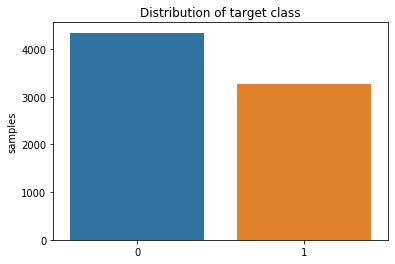

In [11]:
x=train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')
plt.title('Distribution of target class')

/Users/yingshi/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

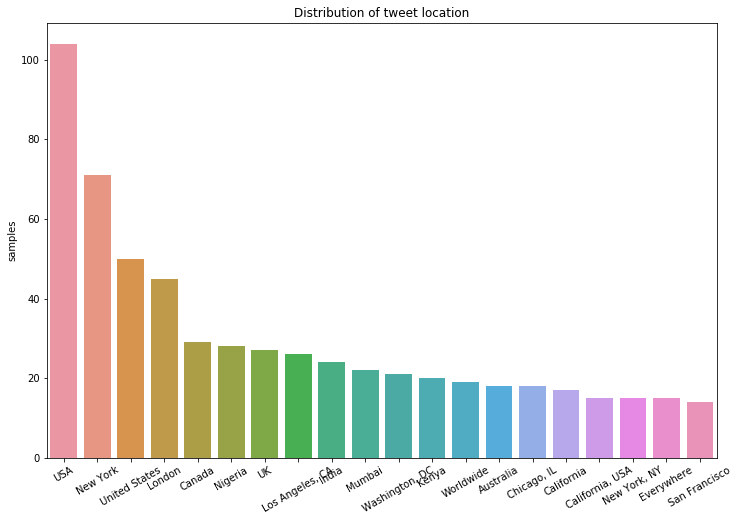

In [15]:
cnt_ = train['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
plt.figure(figsize=(12, 8))
sns.barplot(cnt_.index,cnt_)
plt.gca().set_ylabel('samples')
plt.title('Distribution of tweet location')
plt.xticks(rotation=30)

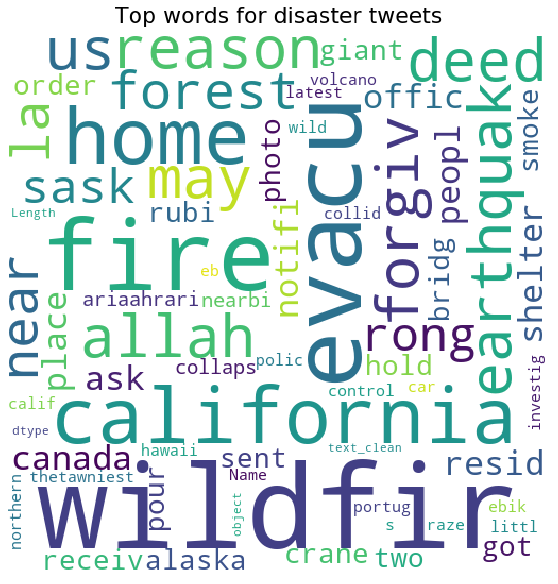

In [43]:
twitter_mask = np.array(Image.open('twitter_mask3.png'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(str(train.loc[train['target'] == 1, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for disaster tweets', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

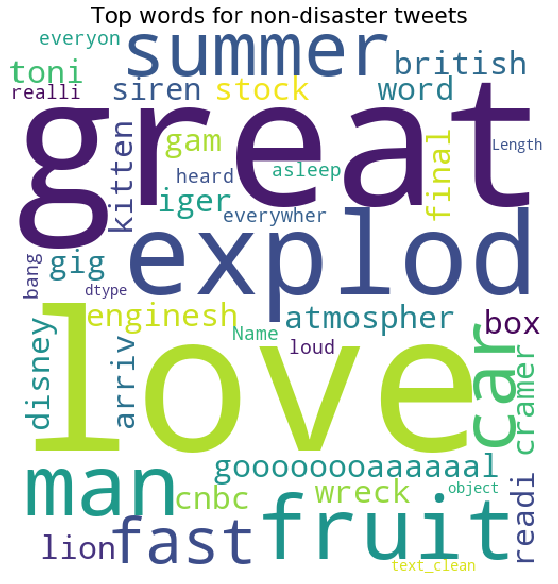

In [47]:
twitter_mask = np.array(Image.open('twitter_mask3.png'))

wc = WordCloud(
    background_color='white', 
    max_words=200, 
    mask=twitter_mask,
)
wc.generate(str(train.loc[train['target'] == 0, 'text_clean']))
plt.figure(figsize=(18,10))
plt.title('Top words for non-disaster tweets', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

# Topic Modelling

In [130]:
notreal_text = train["text_clean"][train["target"] == 0]
real_text = train["text_clean"][train["target"] == 1]
#count vectorization
vectorizer_notreal = CountVectorizer(strip_accents = 'unicode',min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern=r'\b[a-zA-Z]{3,}\b')
notreal_vectorized = vectorizer_notreal.fit_transform(notreal_text)
vectorizer_real = CountVectorizer(strip_accents = 'unicode',min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern=r'\b[a-zA-Z]{3,}\b')
real_vectorized = vectorizer_real.fit_transform(real_text)

In [124]:
def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

## Latent Dirichlet Allocation (LDA)


In [131]:

lda_notreal = LatentDirichletAllocation(n_components=5, max_iter=5, learning_method='online',verbose=True)
lda_notreal.fit(notreal_vectorized)
lda_real = LatentDirichletAllocation(n_components=5, max_iter=5, learning_method='online',verbose=True)
lda_real.fit(real_vectorized)

iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=True)

In [ ]:
print_topics(lda_notreal, vectorizer_notreal)

In [57]:
print_topics(lda_real, vectorizer_real)

Topic 0:
[('disast', 113.88136113571073), ('flood', 86.11308761322924), ('live', 70.1995643306054), ('kill', 47.29693492889186), ('forest', 46.2150617551671), ('migrant', 45.408668512173904), ('wild', 41.62379902258159), ('fear', 39.82452687345834), ('crash', 39.106531853339575), ('plan', 38.686815624171324)]
Topic 1:
[('train', 100.37113185305132), ('derail', 69.42459038326159), ('emerg', 67.62371631061158), ('collaps', 54.00317181442139), ('warn', 43.76119040924682), ('thunderstorm', 43.39737627306234), ('rescuer', 37.27675962835149), ('bodi', 36.30016619522633), ('search', 34.87262367290111), ('home', 34.48994875424562)]
Topic 2:
[('year', 79.94116045977387), ('home', 70.08182856231912), ('peopl', 68.99469965679475), ('attack', 68.54474295099853), ('water', 54.47451639054653), ('latest', 51.81603666286915), ('issu', 48.1502657414823), ('terrorist', 47.21676436278143), ('world', 46.78792121684895), ('terror', 45.50765088243637)]
Topic 3:
[('nuclear', 75.95754893058188), ('amp', 73.47

In [134]:
import pyLDAvis
import pyLDAvis.sklearn
notreal_text = train["text_clean"][train["target"] == 0]
real_text = train["text_clean"][train["target"] == 1]

print('start script')
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',stop_words = 'english',lowercase = True,token_pattern = r'\b[a-zA-Z]{3,}\b',max_df = 0.5,min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(real_text)
lda_tf = LatentDirichletAllocation(n_components=10, learning_method='online')
print('fit')
lda_tf.fit(dtm_tf)

start script
fit


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [140]:
print('prepare')
vis_data = pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer,n_jobs=1 )
print('display')
pyLDAvis.display(vis_data)

prepare


/Users/yingshi/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


display


# GloVe - LSTM

In [141]:
train_tweets = train['text_clean'].values
test_tweets = test['text_clean'].values
train_target = train['target'].values

In [142]:
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [143]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [144]:
#tokenization
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_tweets)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

13687

In [145]:
#Pad_sequences
longest_train = max(train_tweets, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train_tweets), 
    length_long_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test_tweets), 
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[3634,  465,  202, ...,    0,    0,    0],
       [ 136,    1,  105, ...,    0,    0,    0],
       [1337,  500, 1806, ...,    0,    0,    0],
       ...,
       [ 196,  446, 1327, ...,    0,    0,    0],
       [  28,  162, 2636, ...,    0,    0,    0],
       [ 171,   31,  411, ...,    0,    0,    0]], dtype=int32)

In [146]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [147]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.26872   , -0.15542001, -0.23565   , ...,  0.49344   ,
         0.72114003, -0.041749  ],
       [-0.44497001,  0.26159999, -0.17784999, ..., -0.33028001,
         0.58111   ,  0.38205001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.19814   , -0.33517   , -0.13950001, ..., -0.070356  ,
        -0.18391   ,  0.62439001],
       [-0.34132001,  0.26423001,  0.47813001, ..., -0.92395002,
         0.48275   ,  0.52947998]])

In [148]:
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences, 
    train_target, 
    test_size=0.25
)

In [149]:
# Model from https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data
def glove_lstm():
    model = Sequential()
    
    model.add(Embedding(
        input_dim=embedding_matrix.shape[0], 
        output_dim=embedding_matrix.shape[1], 
        weights = [embedding_matrix], 
        input_length=length_long_sentence
    ))
    
    model.add(Bidirectional(LSTM(
        length_long_sentence, 
        return_sequences = True, 
        recurrent_dropout=0.2
    )))
    
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [150]:
%%time
model = glove_lstm()

early_stopping = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 20,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint,early_stopping]
)

Epoch 1/20
177/179 [============================>.] - ETA: 0s - loss: 0.7799 - accuracy: 0.5763
Epoch 00001: val_loss improved from inf to 0.66581, saving model to model.h5
179/179 [==============================] - 11s 29ms/step - loss: 0.7795 - accuracy: 0.5756 - val_loss: 0.6658 - val_accuracy: 0.6560 - lr: 0.0010
Epoch 2/20
179/179 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.6451
Epoch 00002: val_loss improved from 0.66581 to 0.57933, saving model to model.h5
179/179 [==============================] - 5s 26ms/step - loss: 0.6452 - accuracy: 0.6451 - val_loss: 0.5793 - val_accuracy: 0.7511 - lr: 0.0010
Epoch 3/20
177/179 [============================>.] - ETA: 0s - loss: 0.5652 - accuracy: 0.7209
Epoch 00003: val_loss improved from 0.57933 to 0.49113, saving model to model.h5
179/179 [==============================] - 6s 35ms/step - loss: 0.5646 - accuracy: 0.7208 - val_loss: 0.4911 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 4/20
179/179 [=================

In [154]:
model = glove_lstm()

early_stopping = EarlyStopping(patience=5, verbose=1)
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 5,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint,early_stopping]
)

Epoch 1/5
178/179 [============================>.] - ETA: 0s - loss: 0.7758 - accuracy: 0.5730
Epoch 00001: val_loss improved from inf to 0.66246, saving model to model.h5
179/179 [==============================] - 10s 26ms/step - loss: 0.7755 - accuracy: 0.5728 - val_loss: 0.6625 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 2/5
178/179 [============================>.] - ETA: 0s - loss: 0.6363 - accuracy: 0.6487
Epoch 00002: val_loss improved from 0.66246 to 0.55673, saving model to model.h5
179/179 [==============================] - 4s 24ms/step - loss: 0.6363 - accuracy: 0.6486 - val_loss: 0.5567 - val_accuracy: 0.7679 - lr: 0.0010
Epoch 3/5
177/179 [============================>.] - ETA: 0s - loss: 0.5716 - accuracy: 0.7299
Epoch 00003: val_loss improved from 0.55673 to 0.49894, saving model to model.h5
179/179 [==============================] - 4s 25ms/step - loss: 0.5710 - accuracy: 0.7299 - val_loss: 0.4989 - val_accuracy: 0.7757 - lr: 0.0010
Epoch 4/5
178/179 [=====================

In [36]:
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

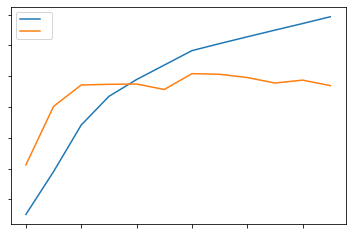

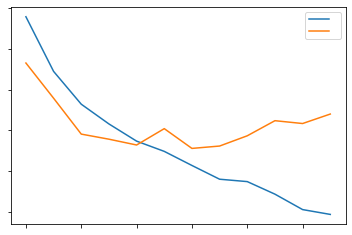

In [151]:
plot_history(history)

In [152]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

60/60 [==============================] - 0s 4ms/step - loss: 0.5404 - accuracy: 0.7847
Loss: 0.5404179692268372
Accuracy: 0.7846638560295105


In [153]:
preds = (model.predict(X_test) > 0.5).astype("int32")
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
metrics(preds, y_test)

F1-score:  0.7385204081632654
Precision:  0.7219451371571073
Recall:  0.7558746736292428
Acuracy:  0.7846638655462185
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      1138
           1       0.72      0.76      0.74       766

    accuracy                           0.78      1904
   macro avg       0.78      0.78      0.78      1904
weighted avg       0.79      0.78      0.79      1904



In [74]:
# Showing Confusion Matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "Blues", linewidths=1,annot=annot, fmt='', ax=ax)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

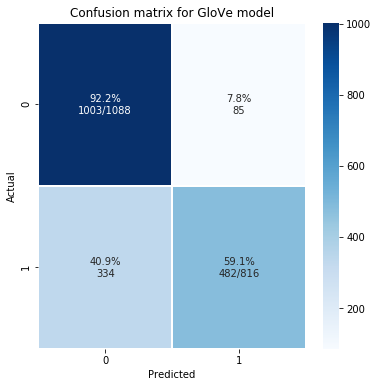

In [76]:
# Showing Confusion Matrix for GloVe model
plot_cm(y_test, preds, 'Confusion matrix for GloVe model', figsize=(6,6))


# BERT

In [84]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py


/bin/sh: wget: command not found


In [97]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from bert import bert_tokenization


In [109]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [110]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [111]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 10.5 s, sys: 1.33 s, total: 11.8 s
Wall time: 12.9 s


In [102]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

## Model: Build, Train, Predict

In [112]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 160)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 160)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 160)]        0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     [(None, 1024),       335141889   ['input_word_ids[0][0]',         
                                 (None, 160, 1024)]               'input_mask[0][0]',       

In [113]:
%%time
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(patience=2, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=10,
    callbacks=[checkpoint,early_stopping,reduce_lr],
    batch_size=16
)


Epoch 1/10
 31/381 [=>............................] - ETA: 2:55:03 - loss: 0.6047 - accuracy: 0.6855

KeyboardInterrupt: 